# Forecasting Resale Car Prices

## Configurations

In [ ]:
car_data = "./Data/cleaned_sgcarmart_used_cars_prices.csv"
coe_data = "./Data/COE Bidding Exercise Data (Full).csv"

## Import Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn import set_config

from Utils.customPipelines import *
from Utils.dataLoader import *
from Utils.pipelineComponents import *
from Utils.customNeuralNet import CustomNN
from Utils.modelDiagnostics import *
    
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
set_config(display="diagram")

%load_ext autoreload
%autoreload 2
# Configurations
RANDOM_STATE = 2021 
pd.options.mode.chained_assignment = None  # default='warn'

# Preprocessing

### Before pipeline

1. COE_FROM_SCRAPE_DATE fill in
2. Remove rows that have unimputable missing columns

### Inside pipeline
1. Dummy variables from categorical values (Categories not in train set shld be Others)
2. Approx median values by CC from COE data
3. Impute median values (assume they forget to input)
4. Remove outliers if training = True

In [4]:
X_train, X_test, y_train, y_test = get_standard_train_test_split(get_clean_car_df(car_data, coe_data))
X_train

Original size: 3987 -> Cleaned size: 3933


,LISTING_URL,BRAND,DEPRE_VALUE_PER_YEAR,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_PER_YEAR,TRANSMISSION,DEREG_VALUE_FROM_SCRAPE_DATE,SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,REG_DATE_DAYS,IS_COE_APPROXIMATED
2392,https://www.sgcarmart.com/used_cars/info.php?I...,BMW,25800.000,2018-10-22,7110.000,2018.000,1210.000,Auto,173581.000,2019-10-23,128350.000,193030.000,31302.000,2958.000,1998,2000.000,1.000,Luxury Sedan,366.000,False
805,https://www.sgcarmart.com/used_cars/info.php?I...,Citroen,8520.000,2017-02-15,61000.000,2016.000,1244.000,Auto,44194.000,2019-10-23,23051.000,9272.000,50889.000,2647.000,1560,1320.000,1.000,MPV,980.000,False
2670,https://www.sgcarmart.com/used_cars/info.php?I...,Mazda,8830.000,2010-08-11,nan,2009.000,742.000,Auto,13302.000,2019-10-23,21468.000,21468.000,33089.000,278.000,1598,1275.000,2.000,Mid-Sized Sedan,3360.000,False
1255,https://www.sgcarmart.com/used_cars/info.php?I...,Toyota,6670.000,2010-01-14,120986.000,2009.000,1638.000,Auto,nan,2019-10-23,30812.000,30812.000,17889.000,0.000,2362,1600.000,1.000,SUV,3569.000,True
2428,https://www.sgcarmart.com/used_cars/info.php?I...,Toyota,10070.000,2017-03-28,33509.000,2017.000,976.000,Auto,54049.000,2019-10-23,19955.000,19955.000,53300.000,2709.000,1798,1360.000,1.000,MPV,939.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,https://www.sgcarmart.com/used_cars/info.php?I...,Ferrari,71540.000,2012-05-11,36000.000,2012.000,4414.000,Auto,192339.000,2019-10-23,289225.000,289225.000,80191.000,917.000,4297,1780.000,5.000,Sports Car,2721.000,False
1164,https://www.sgcarmart.com/used_cars/info.php?I...,Volkswagen,9470.000,2016-03-28,65080.000,2016.000,624.000,Auto,49161.000,2019-10-23,27537.000,25552.000,45504.000,2344.000,1395,1383.000,1.000,Hatchback,1304.000,False
2133,https://www.sgcarmart.com/used_cars/info.php?I...,Honda,8290.000,2009-08-11,91000.000,2008.000,978.000,Auto,19180.000,2019-10-23,26671.000,26671.000,16801.000,1738.000,1799,1219.000,2.000,Mid-Sized Sedan,3725.000,False
3459,https://www.sgcarmart.com/used_cars/info.php?I...,Mitsubishi,8810.000,2009-08-31,101000.000,2009.000,684.000,Auto,14246.000,2019-10-23,16600.000,16600.000,15019.000,1467.000,1499,1313.000,3.000,Mid-Sized Sedan,3705.000,False


# Exploratory Data Analysis

## Check Null Values

In [5]:
X_train.isnull().sum()

LISTING_URL                       0
BRAND                             0
DEPRE_VALUE_PER_YEAR             52
REG_DATE                          0
MILEAGE_KM                      489
MANUFACTURED_YEAR                 1
ROAD_TAX_PER_YEAR               109
TRANSMISSION                      0
DEREG_VALUE_FROM_SCRAPE_DATE    571
SCRAPE_DATE                       0
OMV                               5
ARF                               6
COE_FROM_SCRAPE_DATE              0
DAYS_OF_COE_LEFT                  1
ENGINE_CAPACITY_CC                0
CURB_WEIGHT_KG                   89
NO_OF_OWNERS                     39
VEHICLE_TYPE                      0
REG_DATE_DAYS                     0
IS_COE_APPROXIMATED               0
dtype: int64

## Distribution of Price

DescribeResult(nobs=3146, minmax=(1190.0, 938000.0), mean=83279.95200254291, variance=5419129004.134738, skewness=4.70352349375579, kurtosis=34.20403168206295)

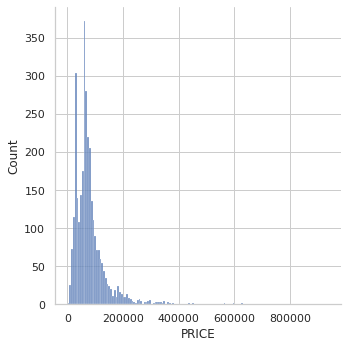

In [6]:
sns.displot(y_train)
stats.describe(y_train)

## Overall Statistics for X Train

In [7]:
X_train.describe()

,DEPRE_VALUE_PER_YEAR,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_PER_YEAR,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,REG_DATE_DAYS
count,3094.000,2657.000,3145.000,3037.000,2575.000,3141.000,3140.000,3146.000,3145.000,3146.000,3057.000,3107.000,3146.000
mean,11526.803,71738.370,2012.656,1165.239,51212.517,34159.747,35822.612,41599.074,1952.075,1889.423,1436.140,1.795,2232.761
std,9727.791,44656.107,4.758,905.145,34777.606,35065.044,44110.566,20340.878,1004.580,669.532,256.631,1.082,1630.123
min,1730.000,3.000,1959.000,50.000,34.000,5201.000,1316.000,2.000,0.000,647.000,795.000,1.000,-17626.000
25%,7390.000,37450.000,2009.000,684.000,35214.000,18232.000,14654.250,19510.000,1466.000,1498.000,1251.000,1.000,1045.750
50%,9250.000,65047.000,2014.000,750.000,46204.000,25133.000,22879.000,45395.000,2099.000,1598.000,1405.000,1.000,1740.000
75%,12747.500,103339.000,2016.000,1210.000,59144.500,37019.000,39486.000,55889.000,2682.000,1998.000,1610.000,2.000,3596.000
max,131070.000,330000.000,2019.000,11550.000,423396.000,487275.000,536003.000,95501.000,3563.000,6749.000,2635.000,6.000,17191.000


## Unprocessed features against target variables

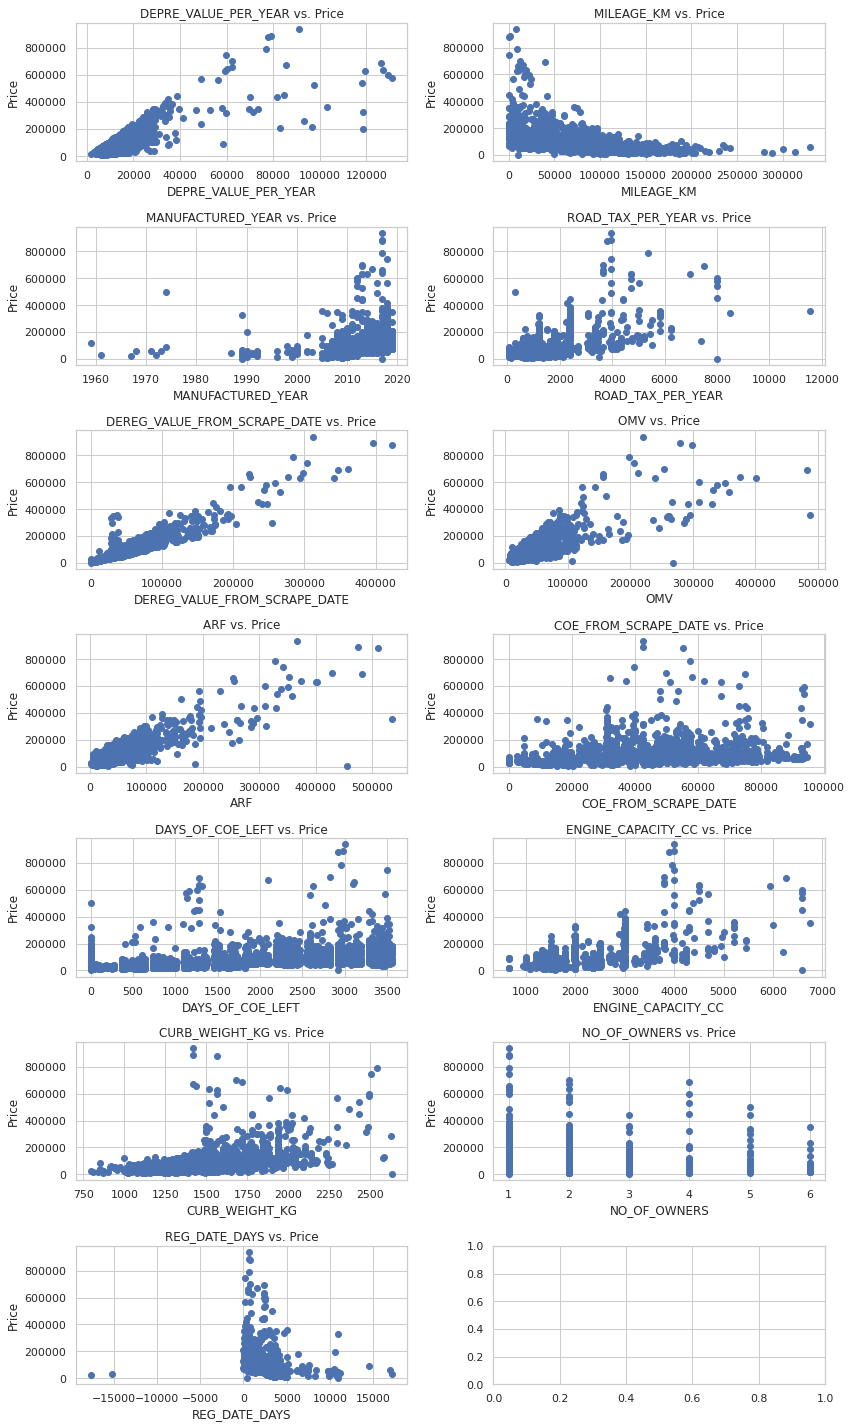

In [8]:
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.values

fig, ax = plt.subplots(len(numerical_cols)//2+1, 2, figsize=(12,20))
ax = ax.flatten()
for i, nc in enumerate(numerical_cols):
    ax[i].scatter(X_train[nc], y_train)
    ax[i].set_title(nc+" vs. Price")
    ax[i].set_xlabel(nc)
    ax[i].set_ylabel("Price")

plt.tight_layout()
plt.show()

## Feature Distribution

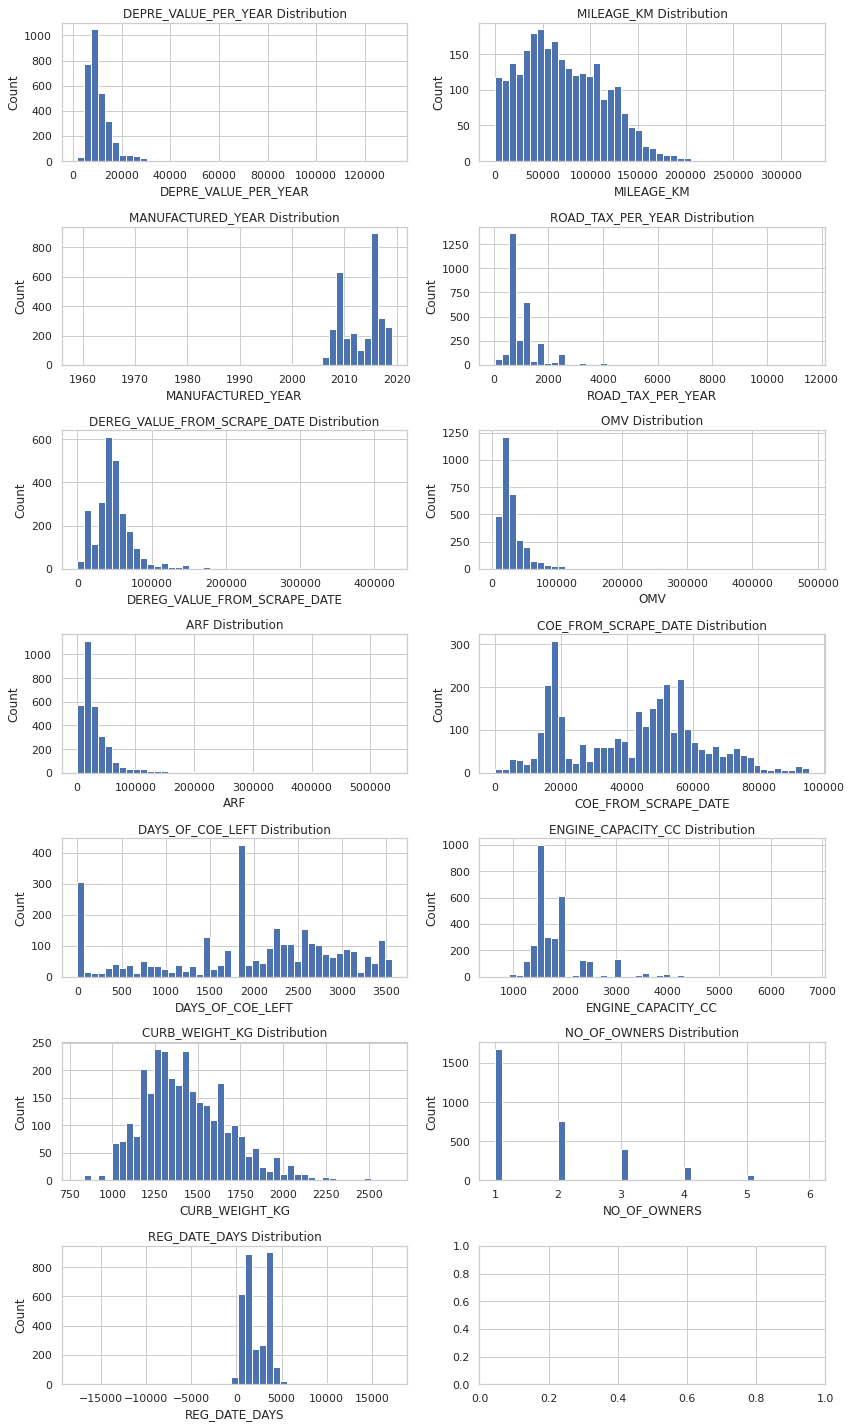

In [9]:
fig, ax = plt.subplots(len(numerical_cols)//2+1, 2, figsize=(12,20))
ax = ax.flatten()
for i, nc in enumerate(numerical_cols):
    ax[i].hist(X_train[nc], bins=45)
    ax[i].set_xlabel(nc)
    ax[i].set_ylabel("Count")
    ax[i].set_title(nc+" Distribution")

plt.tight_layout()
plt.show()

## Distribution of Categorical Variables

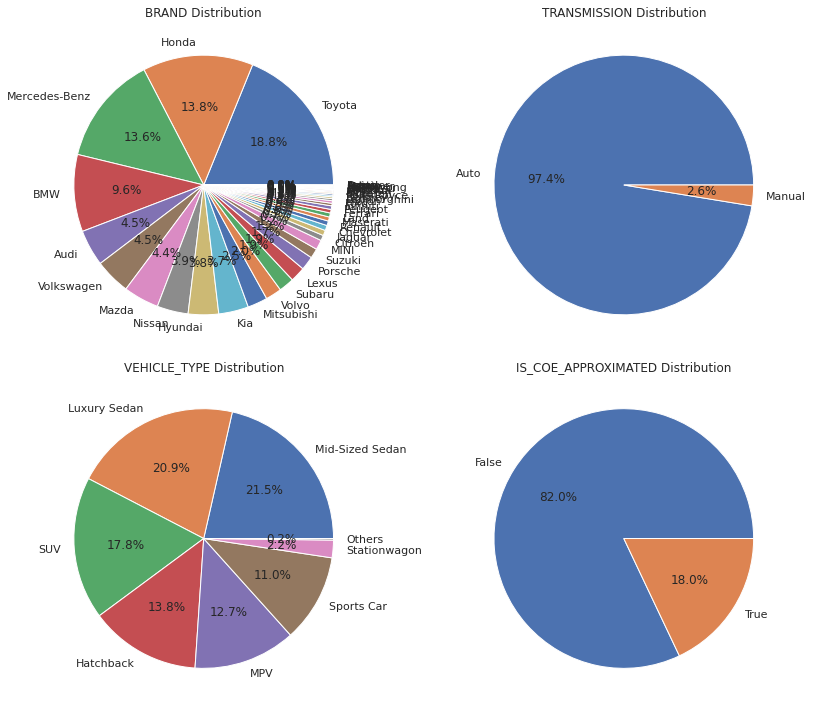

In [10]:
categorical_cols = list(X_train.select_dtypes(include=['object']).columns.values)
categorical_cols.remove('LISTING_URL')

fig, ax = plt.subplots(len(categorical_cols)//2, 2, figsize=(12,10))
ax = ax.flatten()
for i, col in enumerate(categorical_cols):
    ax[i].pie(X_train[col].value_counts(), labels=X_train[col].value_counts().index, autopct='%1.1f%%')
    ax[i].set_title(col+" Distribution")

plt.tight_layout()
plt.show()
    

In [11]:
redacted_cols = ['LISTING_URL', 'REG_DATE','SCRAPE_DATE']

# Categorical
categorical_features = ['BRAND', 'TRANSMISSION', 'VEHICLE_TYPE', 'IS_COE_APPROXIMATED']

# Numerical cols that don't make sense to remove outlier
numerical_features = ['ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG', 'MANUFACTURED_YEAR', 
                      'NO_OF_OWNERS', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_KM', 
                      'ROAD_TAX_PER_YEAR', 'DEREG_VALUE_FROM_SCRAPE_DATE', 
                      'OMV', 'ARF', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT']

# Potentially outlier
outlier_numerical_features = ['REG_DATE_DAYS']

# Feature Selection

We will let the gridsearch guide the selection of the best features for our model. However, we will still perform a feature selection check to visualise and understand what is happening under the hood.

In [12]:
# Clean data, categorically encoded, outlier marked, NaN imputed
pipeline_clean_encode_outlier_impute = get_pipeline_clean_encode_outlier_impute(
  categorical_features=categorical_features,
  numerical_features=numerical_features,
  outlier_numerical_features=outlier_numerical_features,
)

clean_imputed_outlier_X_train = pipeline_clean_encode_outlier_impute.fit_transform(X_train)
clean_imputed_outlier_y_train = y_train

## Collinearity Visualisation

Removed columns: 
['OMV', 'ARF', 'ROAD_TAX_PER_YEAR']


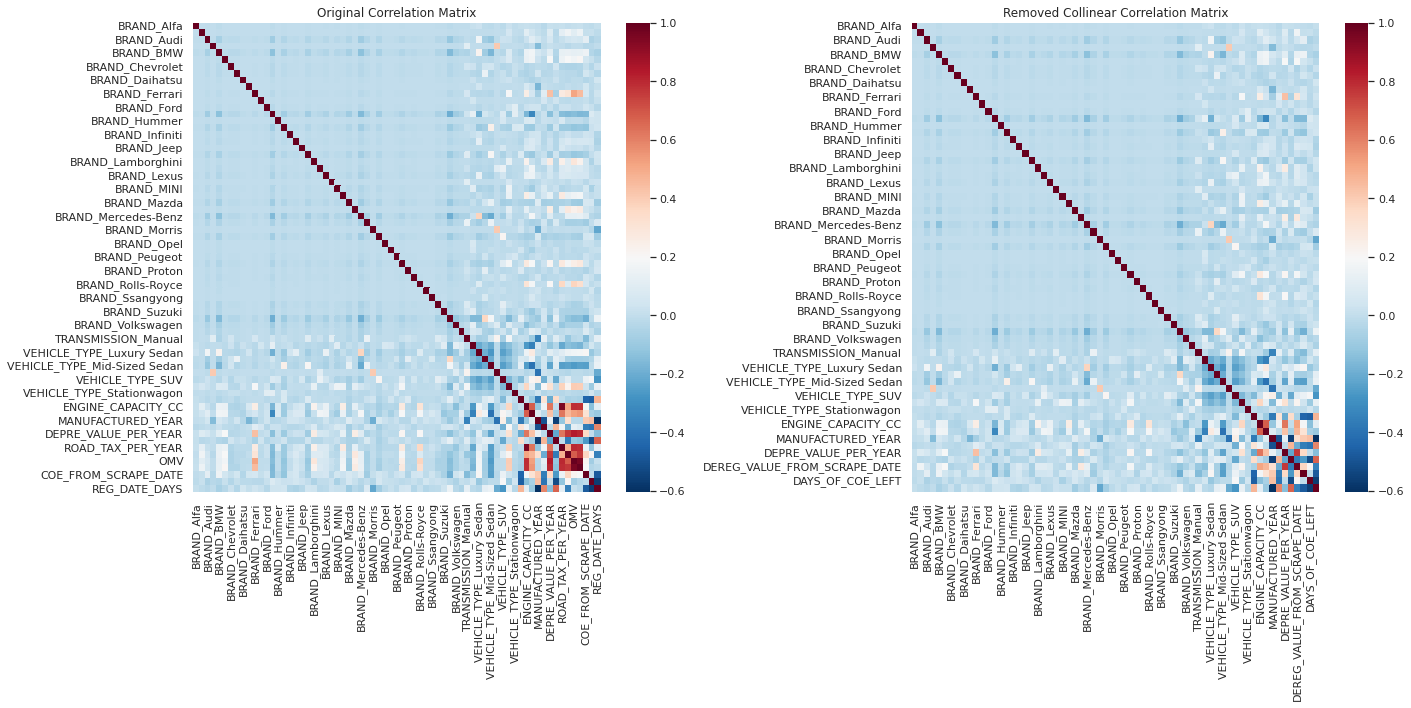

In [13]:
# Visualising correlation matrix
non_corr_impute_X_train = PandasSelectNonCollinear(correlation_threshold=0.8,scoring=f_regression)
removed_corr_features_X_train = non_corr_impute_X_train.fit_transform(clean_imputed_outlier_X_train)

print("Removed columns: ") 
pprint(list(set(clean_imputed_outlier_X_train.columns) - set(non_corr_impute_X_train.columns)))

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax = ax.flatten()
sns.heatmap(clean_imputed_outlier_X_train.corr(), cmap='RdBu_r', ax=ax[0])
sns.heatmap(removed_corr_features_X_train.corr(), cmap='RdBu_r', ax=ax[1])
ax[0].set_title("Original Correlation Matrix")
ax[1].set_title("Removed Collinear Correlation Matrix")
plt.tight_layout()
plt.show()

## PCA

# Features before PCA: 69
# Features after PCA: 54
% Compression: 21.74


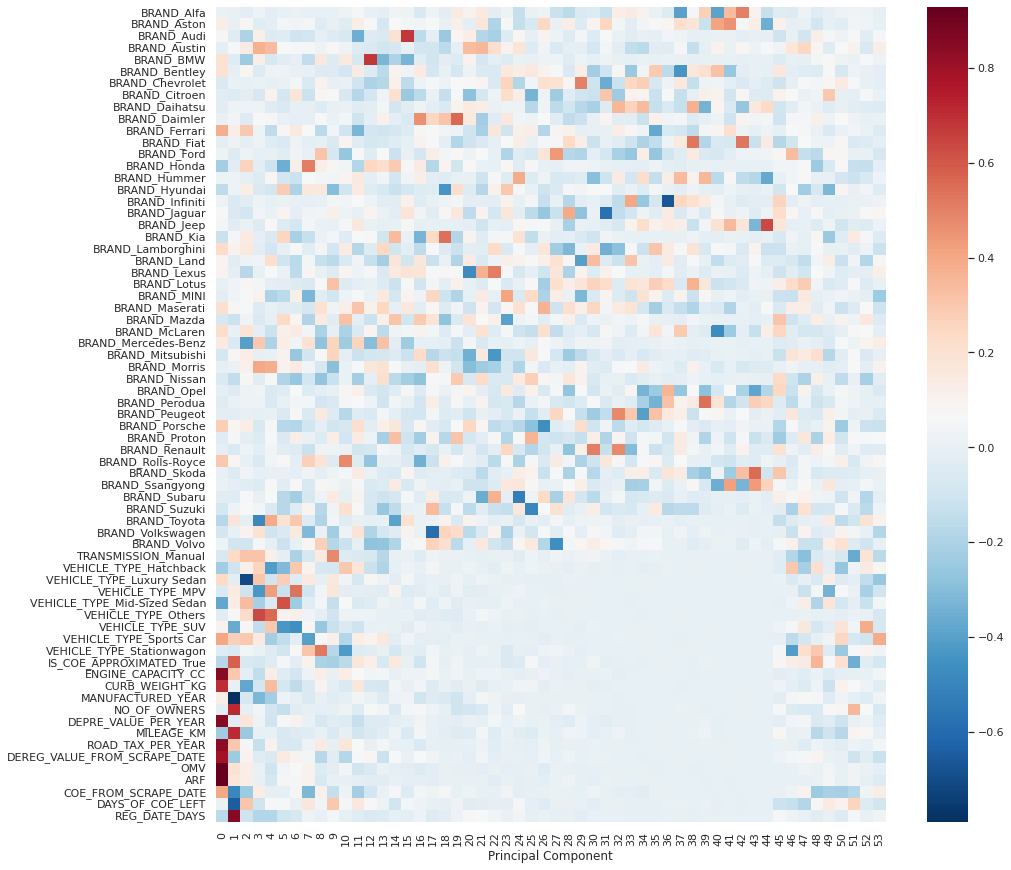

In [14]:
### PCA

custom_pca = PCA(n_components=0.95)
scaled_clean_imputed_outlier_X_train= StandardScaler().fit_transform(clean_imputed_outlier_X_train)
custom_pca.fit(scaled_clean_imputed_outlier_X_train)
custom_pca.explained_variance_ratio_
factor_loadings = custom_pca.components_.T * np.sqrt(custom_pca.explained_variance_)

# Check how many features were changed
print("# Features before PCA:", clean_imputed_outlier_X_train.shape[1])
print("# Features after PCA:", factor_loadings.shape[1])
print("% Compression:", round(100*(1-factor_loadings.shape[1]/clean_imputed_outlier_X_train.shape[1]),2))

# Visualising the factor loadings
fig, ax = plt.subplots(1, 1, figsize=(15,15))
sns.heatmap(pd.DataFrame(factor_loadings, index=clean_imputed_outlier_X_train.columns), cmap='RdBu_r', ax=ax)
ax.set_xlabel('Principal Component')
plt.show()

## Random Forest Feature Selection

In [15]:
clean_index = clean_imputed_outlier_X_train.dropna().index
clean_index_X_train = clean_imputed_outlier_X_train.dropna()
clean_index_y_train = clean_imputed_outlier_y_train[clean_index]

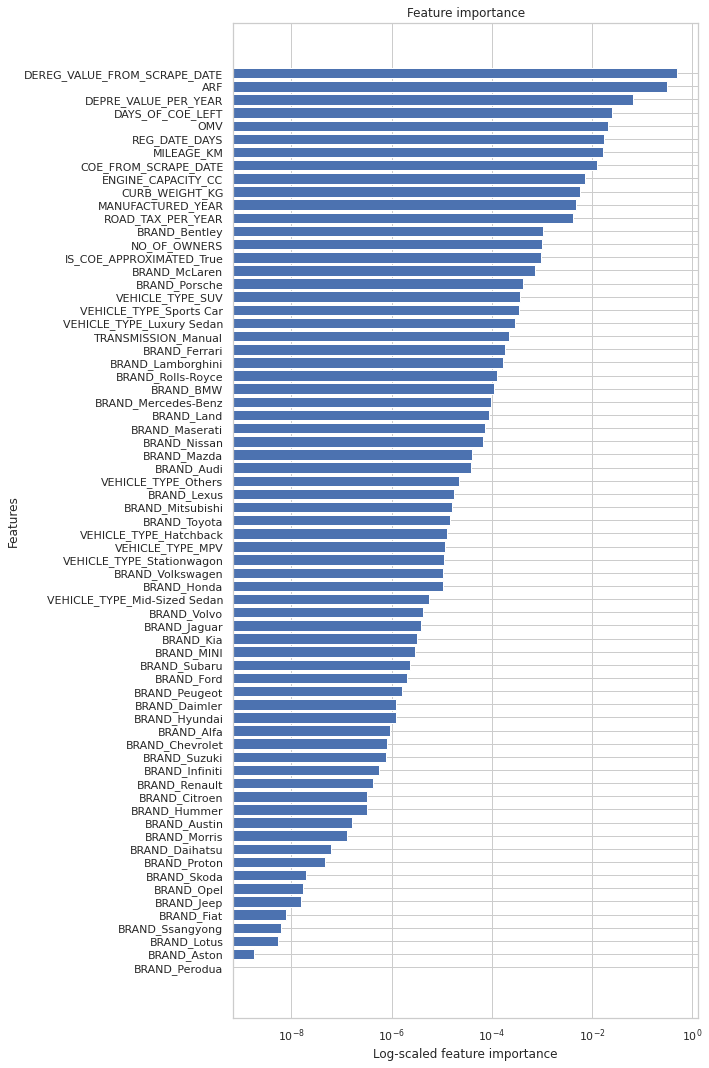

In [16]:
rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(clean_index_X_train, clean_index_y_train)

fig, ax = plt.subplots(1, 1, figsize=(10,15))

X_cols = [clean_index_X_train]
titles = ["before imputing missing values"]
sorted_idx = rfr.feature_importances_.argsort()
ax.barh(clean_index_X_train.columns[sorted_idx], rfr.feature_importances_[sorted_idx])
ax.set_xscale("log")
ax.set_title("Feature importance")
plt.xlabel("Log-scaled feature importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Modelling

Based on best results from `experiments.ipynb` , we have derived the ideal pipeline for each model.


| Model | Best Preprocessing Pipeline | Best Hyperparams |
| ------ | --------------------------- | ---------------- |
| Polynomial Lasso Regression | Random Forest Feature Selection -> MinMax Scaler -> Model | alpha = 0.8, degree = 2, feature selection threshold = 0.5 * median|
| Gradient Boosting Regressor | Standard Scaler -> Model | n_estimators = 200, min_samples_split = 7, min_samples_leaf = 7, max_features = 30, max_depth = 5 |
| Neural Network | Model only | batch_size = 32, hidden_layers = [128, 64, 16, 1], learning_rate = 0.001 |


## Back to Modelling

In [17]:
# Core pipeline component for data processing
pipeline_clean_encode_outlier_impute = get_pipeline_clean_encode_outlier_impute(
  categorical_features=categorical_features,
  numerical_features=numerical_features,
  outlier_numerical_features=outlier_numerical_features,
)
pipeline_clean_encode_outlier_impute

PandasFeatureUnion(transformer_list=[('categorical_pipeline',
                                      Pipeline(steps=[('feature_selector',
                                                       FeatureSelector(feature_names=['BRAND',
                                                                                      'TRANSMISSION',
                                                                                      'VEHICLE_TYPE',
                                                                                      'IS_COE_APPROXIMATED'])),
                                                      ('categorical_imputer',
                                                       CustomImputer(impute_type='categorical')),
                                                      ('encoder',
                                                       CustomOneHotEncoder())])),
                                     ('numerical_pipeline',
                                      Pipeline(steps=[('feature_selector'...
                                                                                      'DEREG_VALUE_FROM_SCRAPE_DATE',
                                                                                      'OMV',
                                                                                      'ARF',
                                                                                      'COE_FROM_SCRAPE_DATE',
                                                                                      'DAYS_OF_COE_LEFT'])),
                                                      ('numerical_imputer',
                                                       CustomImputer())])),
                                     ('outlier_numerical_pipeline',
                                      Pipeline(steps=[('feature_selector',
                                                       FeatureSelector(feature_names=['REG_DATE_DAYS'])),
                                                      ('outlier_handler',
                                                       OutlierHandler(outlier_algorithm='IsolationForest')),
                                                      ('numerical_imputer',
                                                       CustomImputer())]))])

Checking which features are dropped by Random Forest Feature Selector

In [18]:
checking_which_features_dropped = Pipeline([
  ('preprocessed_pipeline', pipeline_clean_encode_outlier_impute),
  ('random_forest_feature_selection', RandomForestFeatureSelector(threshold='0.5*median')),
])
set(pipeline_clean_encode_outlier_impute.fit_transform(X_train, y_train).columns) - set(checking_which_features_dropped.fit_transform(X_train, y_train).columns)

{'BRAND_Alfa',
 'BRAND_Aston',
 'BRAND_Austin',
 'BRAND_Chevrolet',
 'BRAND_Citroen',
 'BRAND_Daihatsu',
 'BRAND_Daimler',
 'BRAND_Fiat',
 'BRAND_Ford',
 'BRAND_Hummer',
 'BRAND_Hyundai',
 'BRAND_Infiniti',
 'BRAND_Jaguar',
 'BRAND_Jeep',
 'BRAND_Kia',
 'BRAND_Lotus',
 'BRAND_MINI',
 'BRAND_Morris',
 'BRAND_Opel',
 'BRAND_Perodua',
 'BRAND_Peugeot',
 'BRAND_Proton',
 'BRAND_Renault',
 'BRAND_Skoda',
 'BRAND_Ssangyong',
 'BRAND_Subaru',
 'BRAND_Suzuki',
 'BRAND_Volkswagen',
 'BRAND_Volvo'}

## Baseline Model (Lasso Regressor)

In [19]:
baseline_model = Pipeline([
  ('preprocessed_pipeline', pipeline_clean_encode_outlier_impute),
  ('standard_scaler', PandasStandardScaler()),
  ('lasso_regressor', Lasso(random_state=RANDOM_STATE))
])

scores = cross_val_score(baseline_model, X_train, y_train, scoring='r2', cv=5)
np.mean(scores)

0.8818069602095795

## Base Estimator 1 - Polynomial Lasso Regression

In [20]:
polynomial_regression_lasso_end_to_end_pipeline = Pipeline([
  ('preprocessed_pipeline', pipeline_clean_encode_outlier_impute),
  ('random_forest_feature_selection', RandomForestFeatureSelector(threshold='0.5*median')),
  ('min_max_scaler', PandasMinMaxScaler()),
  ('polynomial_features', PolynomialFeatures(degree=2)),
  ('lasso_regressor', Lasso(random_state=RANDOM_STATE, alpha=0.8))
])
polynomial_regression_lasso_end_to_end_pipeline

Pipeline(steps=[('preprocessed_pipeline',
                 PandasFeatureUnion(transformer_list=[('categorical_pipeline',
                                                       Pipeline(steps=[('feature_selector',
                                                                        FeatureSelector(feature_names=['BRAND',
                                                                                                       'TRANSMISSION',
                                                                                                       'VEHICLE_TYPE',
                                                                                                       'IS_COE_APPROXIMATED'])),
                                                                       ('categorical_imputer',
                                                                        CustomImputer(impute_type='categorical')),
                                                                       ('encoder',
                                                                        CustomOneHotEncoder())])),
                                                      ('numerical_pipe...
                                                                        FeatureSelector(feature_names=['REG_DATE_DAYS'])),
                                                                       ('outlier_handler',
                                                                        OutlierHandler(outlier_algorithm='IsolationForest')),
                                                                       ('numerical_imputer',
                                                                        CustomImputer())]))])),
                ('random_forest_feature_selection',
                 RandomForestFeatureSelector()),
                ('min_max_scaler', PandasMinMaxScaler()),
                ('polynomial_features', PolynomialFeatures()),
                ('lasso_regressor', Lasso(alpha=0.8, random_state=2021))])

Base Estimator 1 - Polynomial Lasso Regression R2 Score CV (Train): 0.9985363986579525
Base Estimator 1 - Polynomial Lasso Regression R2 Score CV (Test): 0.9183900893491931


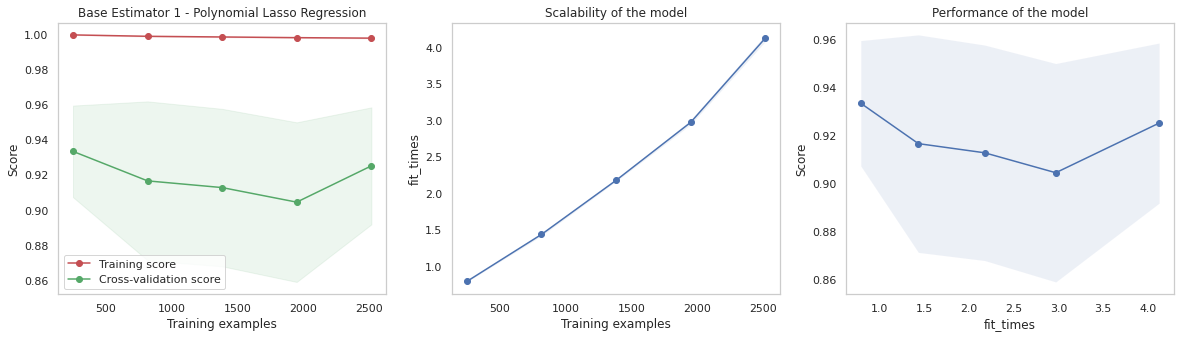

This is without CV - just visualising model predictions


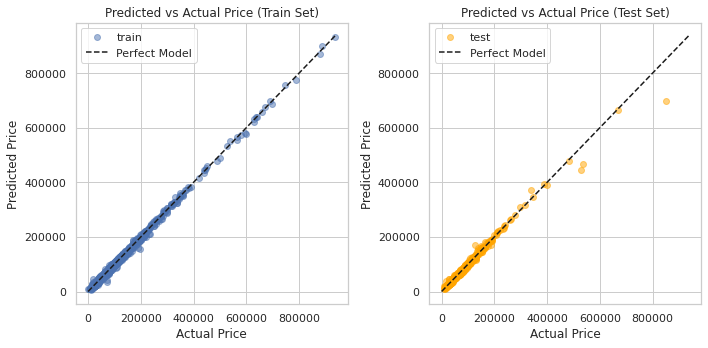

,value
train_r2,0.997
train_rmse,3700.464
test_r2,0.985
test_rmse,7890.655


In [21]:
plot_learning_curve(polynomial_regression_lasso_end_to_end_pipeline, 
                    'Base Estimator 1 - Polynomial Lasso Regression', 
                    X_train, y_train, cv=5)

print("This is without CV - just visualising model predictions")
model_summary(polynomial_regression_lasso_end_to_end_pipeline, X_train, y_train, X_test, y_test)

## Base Estimator 2 - Gradient Boosting Regressor

In [22]:
gradient_boosting_pipeline = Pipeline([
  ('preprocessed_pipeline', pipeline_clean_encode_outlier_impute),
  ('standard_scaler', PandasStandardScaler()),
  ('gradient_boosting_regressor', GradientBoostingRegressor(n_estimators=200, 
                                                            min_samples_split=7, 
                                                            min_samples_leaf=7, 
                                                            max_features=30, 
                                                            max_depth=5, 
                                                            criterion='mse',
                                                            random_state=RANDOM_STATE))
])
gradient_boosting_pipeline

Pipeline(steps=[('preprocessed_pipeline',
                 PandasFeatureUnion(transformer_list=[('categorical_pipeline',
                                                       Pipeline(steps=[('feature_selector',
                                                                        FeatureSelector(feature_names=['BRAND',
                                                                                                       'TRANSMISSION',
                                                                                                       'VEHICLE_TYPE',
                                                                                                       'IS_COE_APPROXIMATED'])),
                                                                       ('categorical_imputer',
                                                                        CustomImputer(impute_type='categorical')),
                                                                       ('encoder',
                                                                        CustomOneHotEncoder())])),
                                                      ('numerical_pipe...
                                                                        FeatureSelector(feature_names=['REG_DATE_DAYS'])),
                                                                       ('outlier_handler',
                                                                        OutlierHandler(outlier_algorithm='IsolationForest')),
                                                                       ('numerical_imputer',
                                                                        CustomImputer())]))])),
                ('standard_scaler', PandasStandardScaler()),
                ('gradient_boosting_regressor',
                 GradientBoostingRegressor(criterion='mse', max_depth=5,
                                           max_features=30, min_samples_leaf=7,
                                           min_samples_split=7,
                                           n_estimators=200,
                                           random_state=2021))])

Base Estimator 2 - Gradient Boosting Regressor R2 Score CV (Train): 0.9966203845499347
Base Estimator 2 - Gradient Boosting Regressor R2 Score CV (Test): 0.8909118154948477


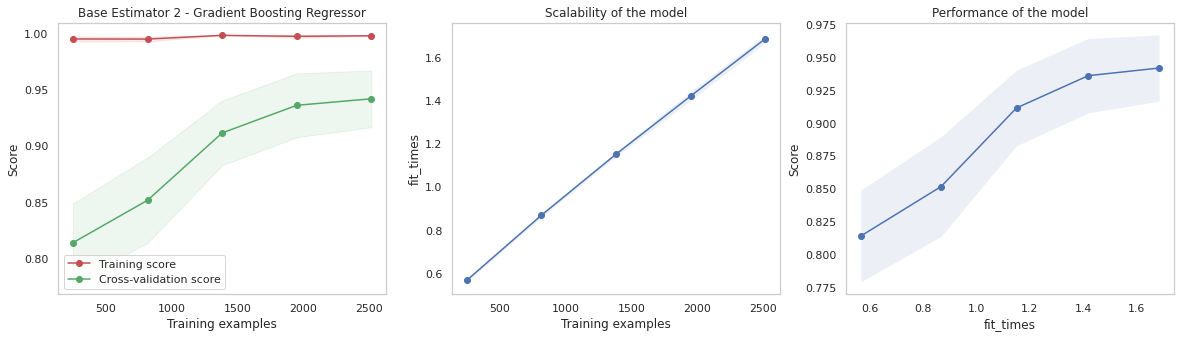

This is without CV - just visualising model predictions


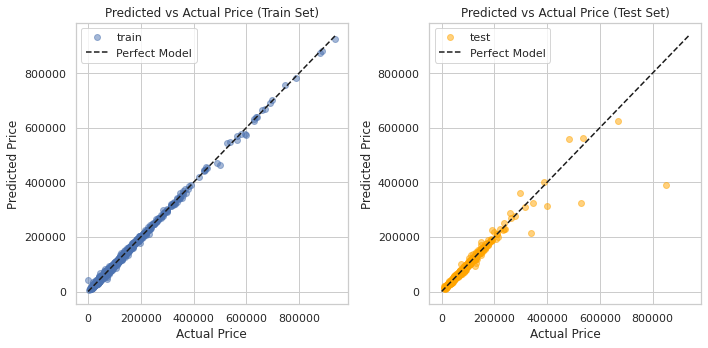

,value
train_r2,0.998
train_rmse,3366.564
test_r2,0.909
test_rmse,19704.969


In [23]:
plot_learning_curve(gradient_boosting_pipeline, 
                    'Base Estimator 2 - Gradient Boosting Regressor', 
                    X_train, y_train, cv=5)

print("This is without CV - just visualising model predictions")
model_summary(gradient_boosting_pipeline, X_train, y_train, X_test, y_test)

## Base Estimator 3 - Neural Network, MLP

In [24]:
nn_pipeline = Pipeline([
  ('preprocessed_pipeline', pipeline_clean_encode_outlier_impute),
  ('nn', CustomNN(verbose=0,
                  learning_rate=0.001,
                  hidden_layer_sizes=(128, 64, 16, 1),
                  batch_size=32,
                  ))
])
nn_pipeline

Pipeline(steps=[('preprocessed_pipeline',
                 PandasFeatureUnion(transformer_list=[('categorical_pipeline',
                                                       Pipeline(steps=[('feature_selector',
                                                                        FeatureSelector(feature_names=['BRAND',
                                                                                                       'TRANSMISSION',
                                                                                                       'VEHICLE_TYPE',
                                                                                                       'IS_COE_APPROXIMATED'])),
                                                                       ('categorical_imputer',
                                                                        CustomImputer(impute_type='categorical')),
                                                                       ('encoder',
                                                                        CustomOneHotEncoder())])),
                                                      ('numerical_pipe...
                                                                                                       'DAYS_OF_COE_LEFT'])),
                                                                       ('numerical_imputer',
                                                                        CustomImputer())])),
                                                      ('outlier_numerical_pipeline',
                                                       Pipeline(steps=[('feature_selector',
                                                                        FeatureSelector(feature_names=['REG_DATE_DAYS'])),
                                                                       ('outlier_handler',
                                                                        OutlierHandler(outlier_algorithm='IsolationForest')),
                                                                       ('numerical_imputer',
                                                                        CustomImputer())]))])),
                ('nn',
                 CustomNN(batch_size=32, hidden_layer_sizes=(128, 64, 16, 1)))])

Base Estimator 3 - Neural Network R2 Score CV (Train): 0.9625488785706677
Base Estimator 3 - Neural Network R2 Score CV (Test): 0.9245303547286131


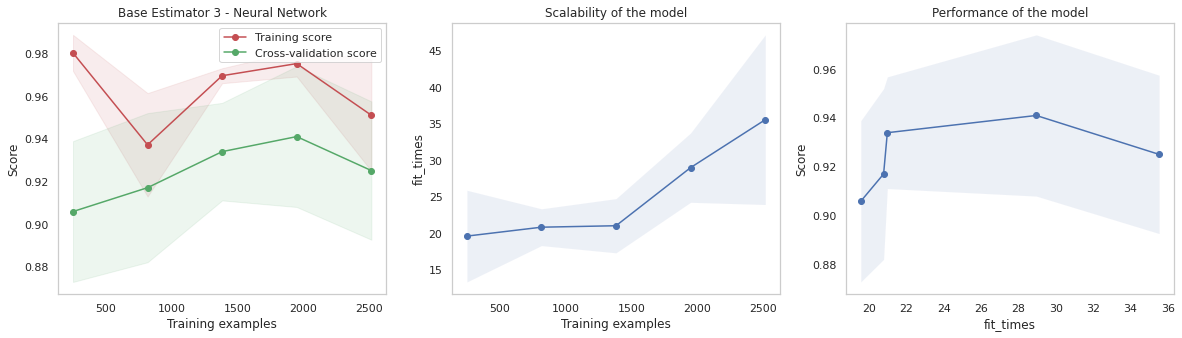

This is without CV - just visualising model predictions


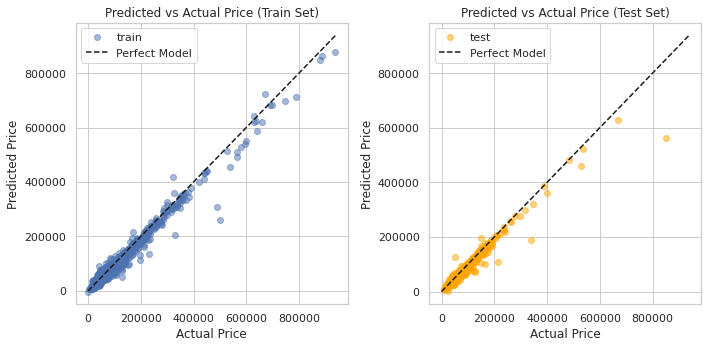

,value
train_r2,0.975
train_rmse,11675.542
test_r2,0.943
test_rmse,15580.975


In [25]:
plot_learning_curve(nn_pipeline, 
                    'Base Estimator 3 - Neural Network', 
                    X_train, y_train, cv=5)

print("This is without CV - just visualising model predictions")
model_summary(nn_pipeline, X_train, y_train, X_test, y_test)

## Stacking Regressor

In [26]:
model_pipelines = [
    ("nn_pipeline", nn_pipeline),
    ("gbr_pipeline", gradient_boosting_pipeline),
    ("poly_pipeline", polynomial_regression_lasso_end_to_end_pipeline)
]
final_pipeline = StackingRegressor(estimators=model_pipelines, n_jobs=1, verbose=1) # n_jobs = 1 to account for keras issues
final_pipeline

StackingRegressor(estimators=[('nn_pipeline',
                               Pipeline(steps=[('preprocessed_pipeline',
                                                PandasFeatureUnion(transformer_list=[('categorical_pipeline',
                                                                                      Pipeline(steps=[('feature_selector',
                                                                                                       FeatureSelector(feature_names=['BRAND',
                                                                                                                                      'TRANSMISSION',
                                                                                                                                      'VEHICLE_TYPE',
                                                                                                                                      'IS_COE_APPROXIMATED'])),
                                                                                                      ('categorical_imputer',
                                                                                                       CustomImputer(impute_type='categorical')),
                                                                                                      ('encode...
                                                                                                       FeatureSelector(feature_names=['REG_DATE_DAYS'])),
                                                                                                      ('outlier_handler',
                                                                                                       OutlierHandler(outlier_algorithm='IsolationForest')),
                                                                                                      ('numerical_imputer',
                                                                                                       CustomImputer())]))])),
                                               ('random_forest_feature_selection',
                                                RandomForestFeatureSelector()),
                                               ('min_max_scaler',
                                                PandasMinMaxScaler()),
                                               ('polynomial_features',
                                                PolynomialFeatures()),
                                               ('lasso_regressor',
                                                Lasso(alpha=0.8,
                                                      random_state=2021))]))],
                  n_jobs=1, verbose=1)

This is without CV - just visualising model predictions


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.0s finished


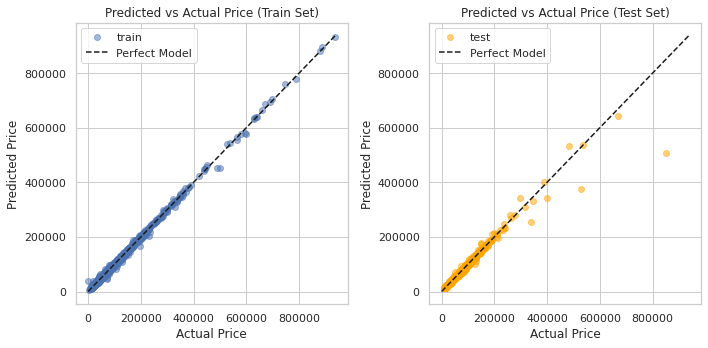

,value
train_r2,0.998
train_rmse,3464.429
test_r2,0.950
test_rmse,14644.923


In [37]:
# NOTE: Stacking Regressor takes too long to do learning curve plot
# plot_learning_curve(final_pipeline, 
#                     'Base Estimator 3 - Neural Network', 
#                     X_train, y_train, cv=2)

print("This is without CV - just visualising model predictions")
model_summary(final_pipeline, X_train, y_train, X_test, y_test)

In [38]:
print("Stacking Regressor Ridge CV Final Estimator Weights:", final_pipeline.final_estimator_.coef_)

Stacking Regressor Ridge CV Final Estimator Weights: [0.1133728  0.63098478 0.26012325]


This is the baseline model


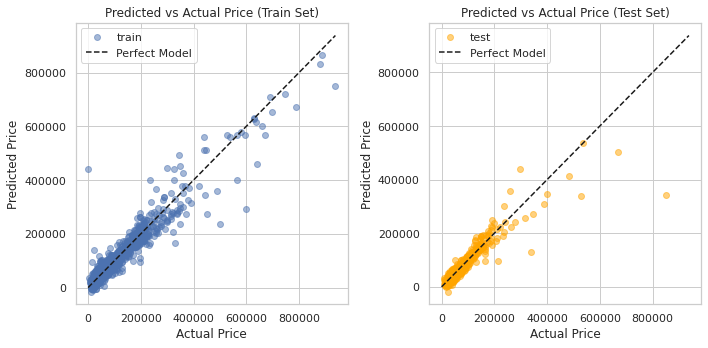

,value
train_r2,0.918
train_rmse,21031.143
test_r2,0.833
test_rmse,26723.937


In [29]:
print("This is the baseline model")
model_summary(baseline_model, X_train, y_train, X_test, y_test)

# Error Analysis

For the stacking regressor, we see that prices above $300,000 are not predicted well, with high RSME. To understand why, we will explore the features that are going in.

In [30]:
y_test_above_300_00_idx = y_test[y_test > 300_000].index
X_test_above_300_000 = X_test.loc[y_test_above_300_00_idx]

y_train_above_300_00_idx = y_train[y_train > 300_000].index
X_train_above_300_000 = X_train.loc[y_train_above_300_00_idx]

processed_X_train_above_300_000 = pipeline_clean_encode_outlier_impute.fit_transform(X_train_above_300_000)
processed_X_test_above_300_000 = pipeline_clean_encode_outlier_impute.transform(X_test_above_300_000)

processed_X_train_above_300_000['train_or_test'] = 'train'
processed_X_train_above_300_000['y'] = y_train[y_train > 300_000]
processed_X_test_above_300_000['train_or_test'] = 'test'
processed_X_test_above_300_000['y'] = y_test[y_test > 300_000]

error_analysis_df = pd.concat([processed_X_train_above_300_000, processed_X_test_above_300_000])

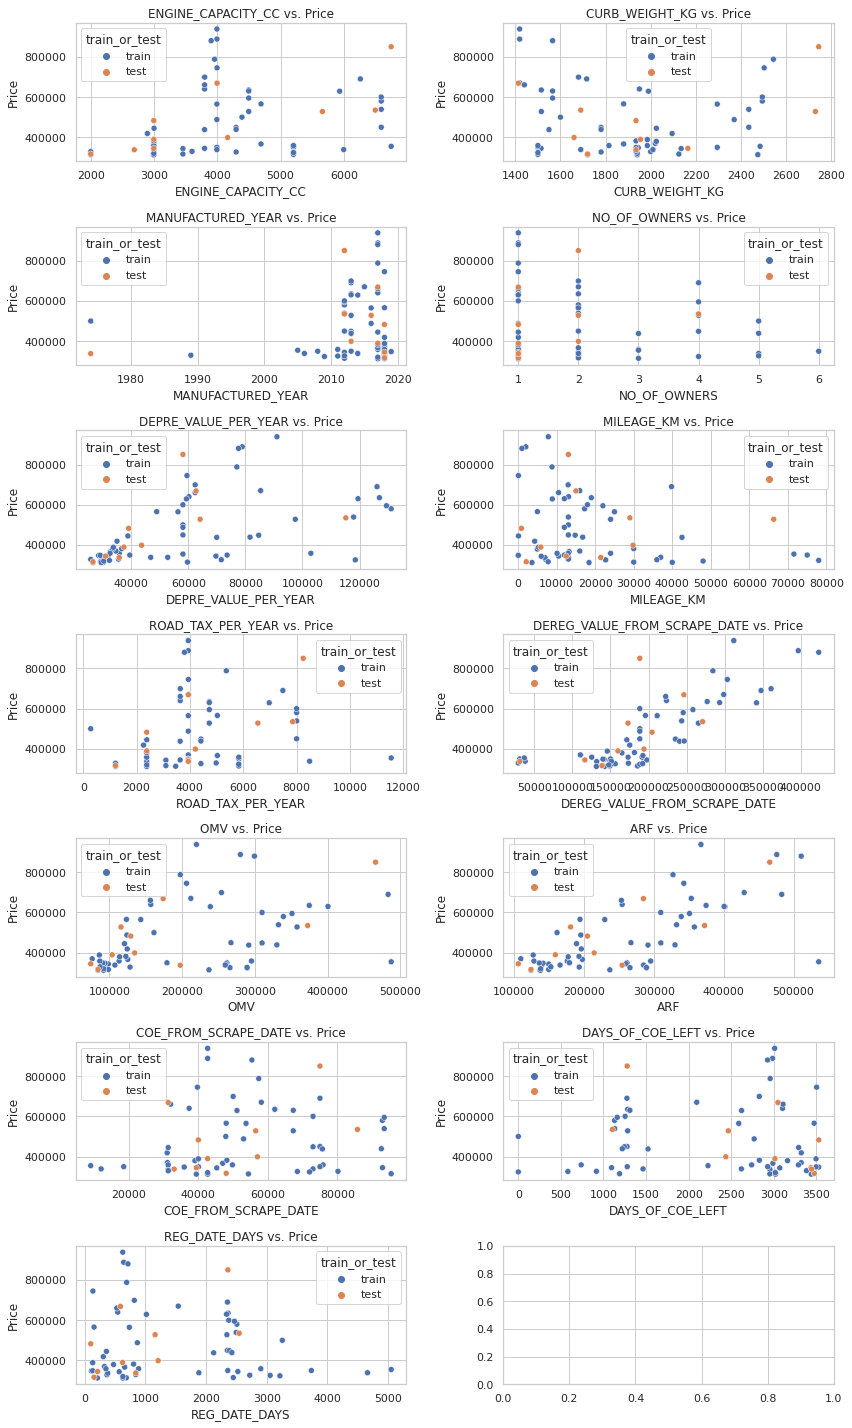

In [31]:
numerical_cols = ['ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG', 'MANUFACTURED_YEAR',
       'NO_OF_OWNERS', 'DEPRE_VALUE_PER_YEAR', 'MILEAGE_KM',
       'ROAD_TAX_PER_YEAR', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE_DAYS']

fig, ax = plt.subplots(len(numerical_cols)//2+1, 2, figsize=(12,20))
ax = ax.flatten()
for i, nc in enumerate(numerical_cols):
    sns.scatterplot(x=error_analysis_df[nc], y=error_analysis_df['y'], hue=error_analysis_df['train_or_test'], ax=ax[i])
    ax[i].set_title(nc+" vs. Price")
    ax[i].set_xlabel(nc)
    ax[i].set_ylabel("Price")

plt.tight_layout()
plt.show()

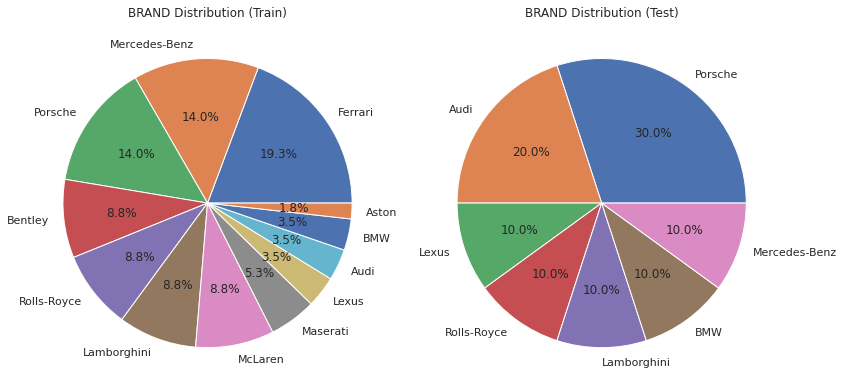

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,10))
ax = ax.flatten()
col = 'BRAND'
ax[0].pie(X_train_above_300_000[col].value_counts(), labels=X_train_above_300_000[col].value_counts().index, autopct='%1.1f%%')
ax[0].set_title(col+" Distribution (Train)")

ax[1].pie(X_test_above_300_000[col].value_counts(), labels=X_test_above_300_000[col].value_counts().index, autopct='%1.1f%%')
ax[1].set_title(col+" Distribution (Test)")

plt.tight_layout()
plt.show()
    

From the above, we observe that for test set numerical features for cars that resell above $300,000, these features appear to be from a similar distribution from the test set, yet they produce a much higher price. Therefore this could suggest that the model is failing to generalise from these features.

# Extracting Final Model Feature Importances

## Gradient Boosting Regressor

In [33]:
final_feat_importance = final_pipeline.named_estimators_\
    .gbr_pipeline.named_steps['gradient_boosting_regressor'].feature_importances_
cols = pipeline_clean_encode_outlier_impute.fit_transform(X_train, y_train).columns

pd.DataFrame(final_feat_importance, index=cols, columns=['Feature Importance'])\
    .sort_values('Feature Importance', ascending=False).head(10)

,Feature Importance
DEPRE_VALUE_PER_YEAR,0.280
DEREG_VALUE_FROM_SCRAPE_DATE,0.223
OMV,0.139
ARF,0.130
ENGINE_CAPACITY_CC,0.059
DAYS_OF_COE_LEFT,0.047
REG_DATE_DAYS,0.039
MILEAGE_KM,0.030
MANUFACTURED_YEAR,0.021
COE_FROM_SCRAPE_DATE,0.012
